In [ ]:
# !pip install plotly
# !pip install matplotlib==3.5.0

In [216]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher
import seaborn as sns

In [2]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)


In [3]:
all_data = pd.read_pickle('data/morbilidad_global.csv')

In [59]:
all_data = all_data[all_data['YEAR']>=2018]
all_data = all_data[all_data['YEAR']<2022]

all_data['IS_LIMA'] = all_data['PROVINCE'].apply(lambda x : True if x=='LIMA' else False)
all_data['SECTOR2'] = all_data['SECTOR'].apply(lambda x: x if x == 'PRIVADO' else 'PUBLICO')


In [60]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,IS_LIMA,SECTOR2
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,10,PELVIC AND PERINEAL PAIN,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVADO
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,11,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVADO
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,3,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVADO
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVADO
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,1,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVADO


In [ ]:
diagnostics_tag = np.unique(all_data['DISEASE_GROUP'])

In [217]:
name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnostics_tag)))

dict_colors = {}
counter = 0
for d in diagnostics_tag:
    x=colors[counter]
    dict_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

In [219]:
dict_colors

{'Abnormal clinical and laboratory symptoms, signs, and findings, not elsewhere classified': '#ff0029',
 'Codes for special situations': '#ff1200',
 'Congenital malformations, deformities and chromosomal abnormalities': '#ff5300',
 'Digestive system diseases': '#ff8e00',
 'Diseases of the blood and hematopoietic organs and other disorders affecting the mechanism of immunity': '#ffcf00',
 'Diseases of the circulatory system': '#eeff00',
 'Diseases of the ear and mastoid process': '#b2ff00',
 'Diseases of the eye and its adnexa': '#72ff00',
 'Diseases of the genitourinary system': '#31ff00',
 'Diseases of the musculoskeletal system and connective tissue': '#00ff0b',
 'Diseases of the skin and subcutaneous tissue': '#00ff4b',
 'Endocrine, nutritional and metabolic diseases': '#00ff8c',
 'External causes of morbidity and mortality': '#00ffc7',
 'Factors influencing health status and contact with health services': '#00f6ff',
 'Injuries, poisoning and some other consequences of external caus

#### ALL PERU

In [220]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.reset_index(drop=True)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

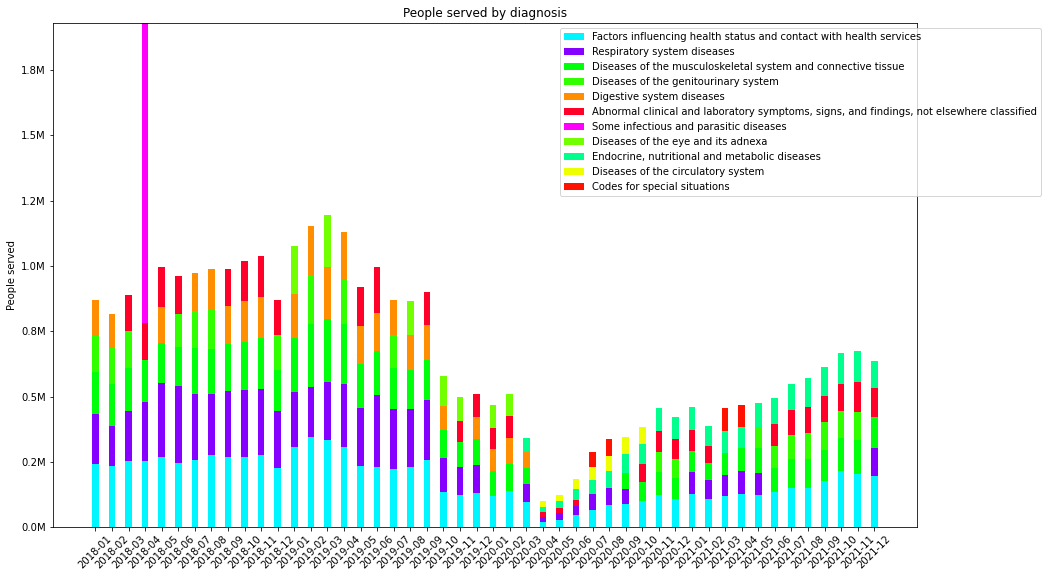

In [221]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

### Lima and Peru

In [64]:
PARAMETER = 'IS_LIMA'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

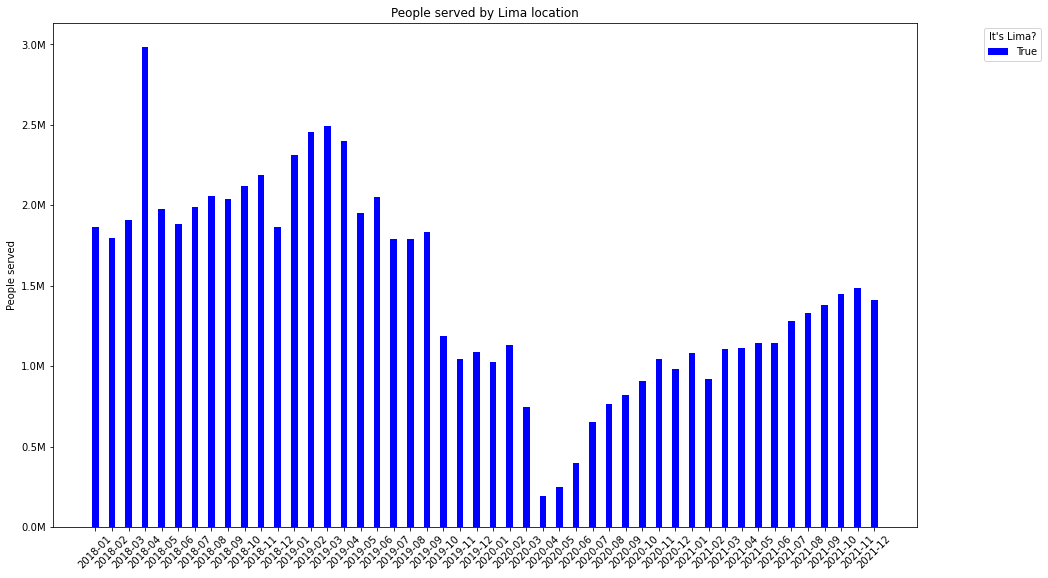

In [65]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "winter"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by Lima location')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1), title = "It's Lima?")
plt.show()

# Only Lima

In [66]:
all_data = all_data[all_data['IS_LIMA']==True]

In [67]:
data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp = data_temp.rename(columns={'sum': 'People_served', 'count': 'Unique_diagnosis'})

### Forecast

### Top 10 diagnosis 

In [12]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

Sanity check for IHM using respiratory deseases. In IHM profile respiratory desease is 8% for Peru while in our Lima dataset we have arronf 9%


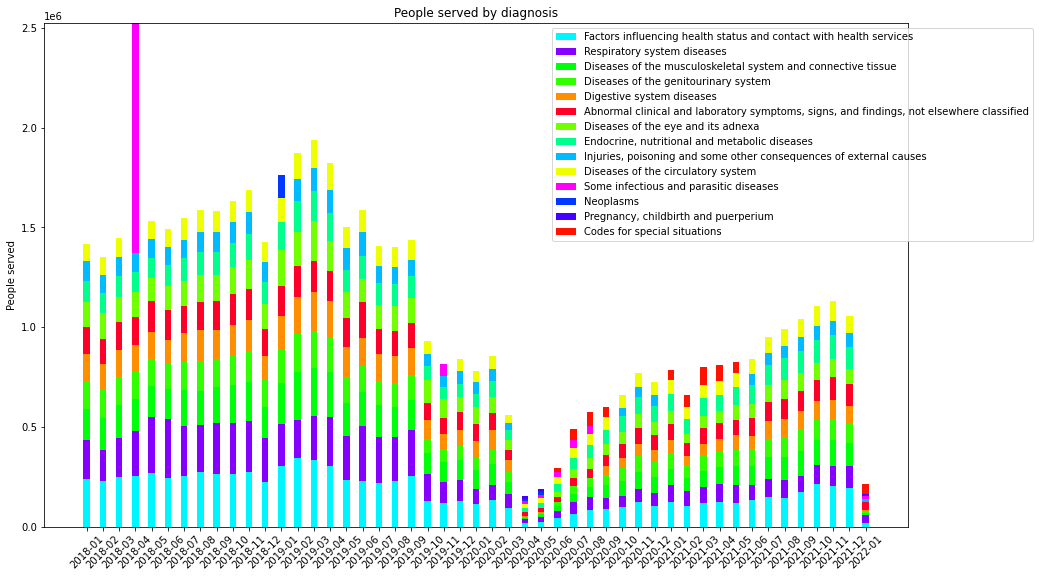

In [14]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40


fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45) 

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

In [13]:
# solo enfermedades respiratorias

#top_df = top_df[top_df['DISEASE_GROUP']=='Respiratory system diseases']
#print(np.mean(top_df['PER']))

# ABC: Referencia - https://www.healthdata.org/peru


### Diagnoses qty by hospitals and hospital category

In [36]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)

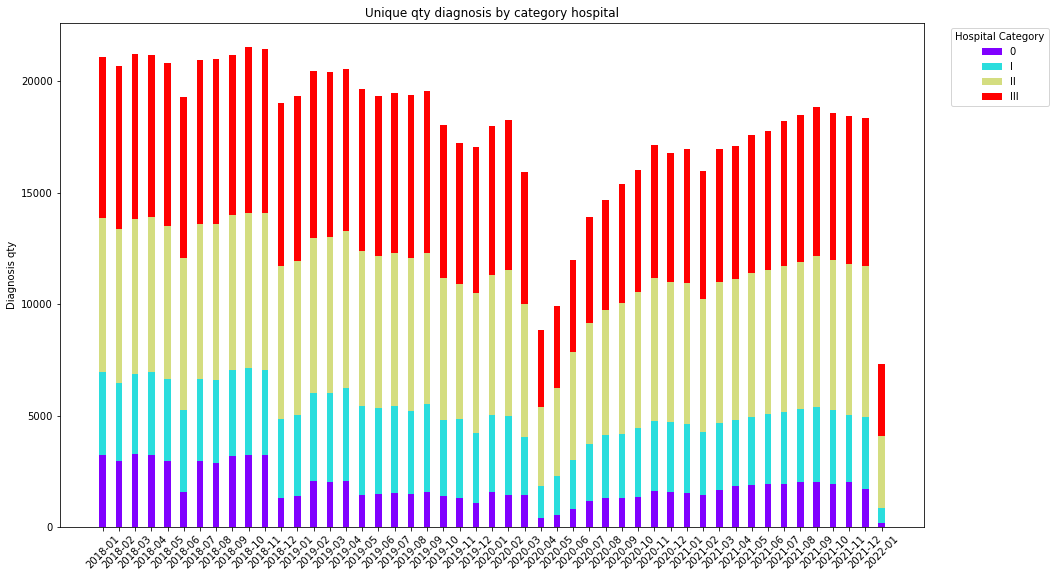

In [37]:
PARAMETER_COL = 'CATEGORY2'

category2 = data_temp[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp['DATE'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.40

name = "rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(category2)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for p in category2:
    temp_df = data_temp[data_temp[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('Diagnosis qty')
ax.set_title('Unique qty diagnosis by category hospital')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=category2, bbox_to_anchor = (1.15, 1), title = "Hospital Category")
plt.show()

## People qty by hospitals and hospital category

In [68]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp_dq = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)
data_temp_dq = data_temp_dq.rename(columns={"QTY_PEOPLE_SERVED": "Diagnosis qty"})

data_temp = all_data[all_data['CATEGORY2']!='ABC']
# data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
# data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp_ps = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)
data_temp_ps = data_temp_ps.rename(columns={"QTY_PEOPLE_SERVED": "People served"})

### Estudio por categorias y diagnosticos

In [69]:
CATEGORIA_STUDIO = '0'

C:\Users\johnk\AppData\Local\Temp/ipykernel_13332/2712260992.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_p['out'] = data_temp_p['People served'].apply(lambda x :
C:\Users\johnk\AppData\Local\Temp/ipykernel_13332/2712260992.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x :
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a 

<AxesSubplot:xlabel='Diagnosis qty', ylabel='Density'>

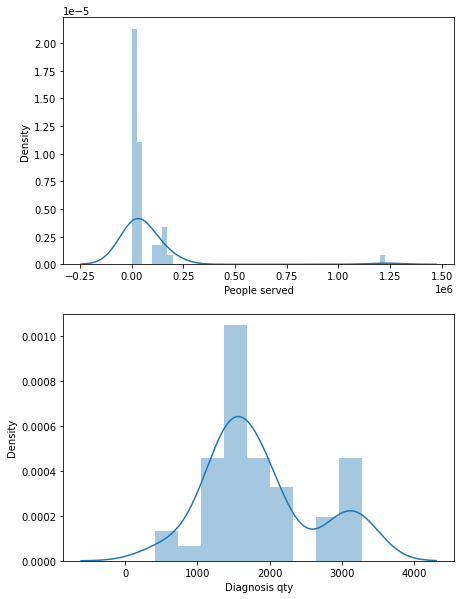

In [70]:
#### Categoria 0

data_temp_p = data_temp_ps[data_temp_ps['CATEGORY2']==CATEGORIA_STUDIO]
data_temp_d = data_temp_dq[data_temp_dq['CATEGORY2']==CATEGORIA_STUDIO]


people_served_max = data_temp_p['People served'].mean() + 1*data_temp_p['People served'].std()
people_served_min = data_temp_p['People served'].mean() - 1*data_temp_p['People served'].std()
unique_diagnosis_max = data_temp_d['Diagnosis qty'].mean() + 1*data_temp_d['Diagnosis qty'].std()
unique_diagnosis_min = data_temp_d['Diagnosis qty'].mean() - 1*data_temp_d['Diagnosis qty'].std()

data_temp_p['out'] = data_temp_p['People served'].apply(lambda x : 
                                                           0 if (people_served_min>x or
                                                                 people_served_max<x)
                                                           else x)

data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x : 
                                                           0 if (unique_diagnosis_min>x or
                                                                 unique_diagnosis_max<x)
                                                           else x)

plt.figure(figsize=(7,10))

plt.subplot(2,1,1)
sns.distplot(data_temp_p['People served'])
plt.subplot(2,1,2)
sns.distplot(data_temp_d['Diagnosis qty'])

C:\Users\johnk\AppData\Local\Temp/ipykernel_13332/1846940798.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


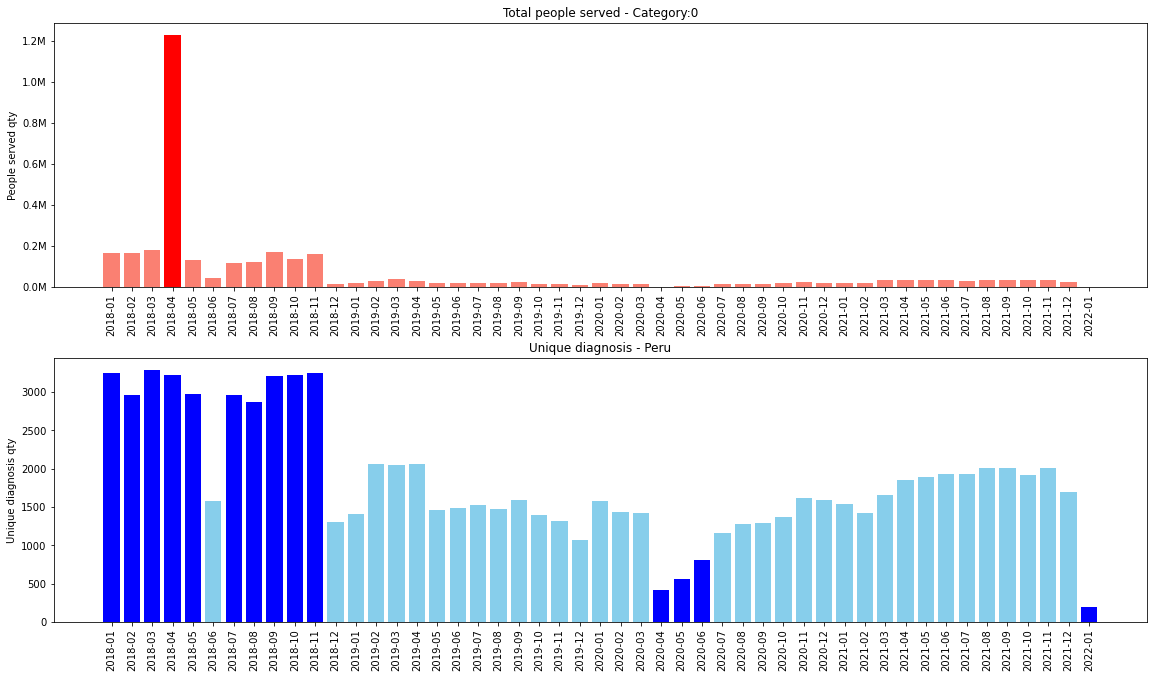

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp_p['DATE'])]

y = list(data_temp_p['People served'])
ax[0].bar(x, y, color='red')
y = list(data_temp_p['out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Category:'+CATEGORIA_STUDIO)
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp_d['Diagnosis qty'])
ax[1].bar(x, y, color='blue')
y = list(data_temp_d['out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

#### Diagnosis to Cat 0

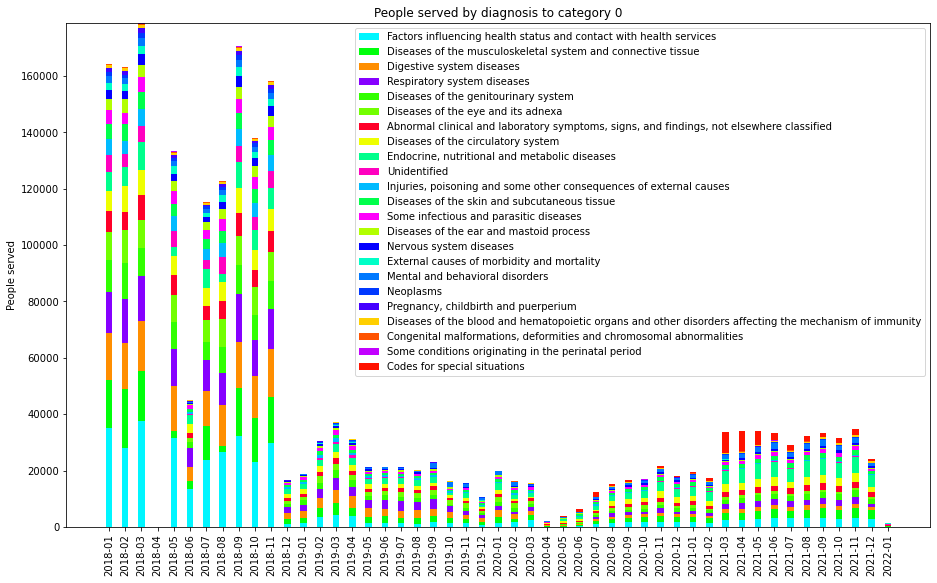

In [54]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    #temp_df = temp_df.head(10).reset_index(drop=True)
    temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    #temp_df = temp_df.reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)


top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+CATEGORIA_STUDIO)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1))
plt.show()

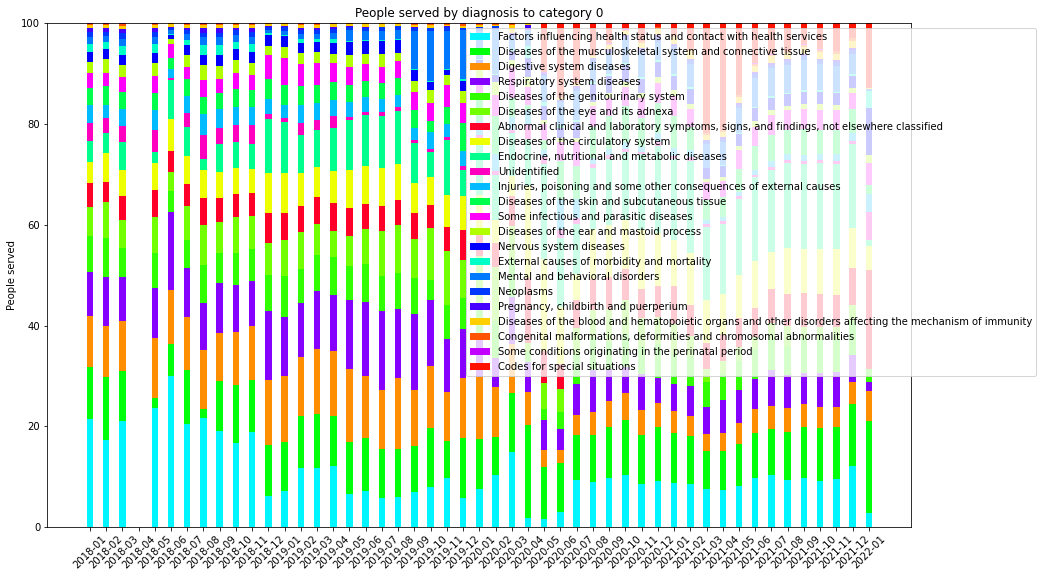

In [55]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['PER'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category '+CATEGORIA_STUDIO)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1), loc=1)
plt.show()

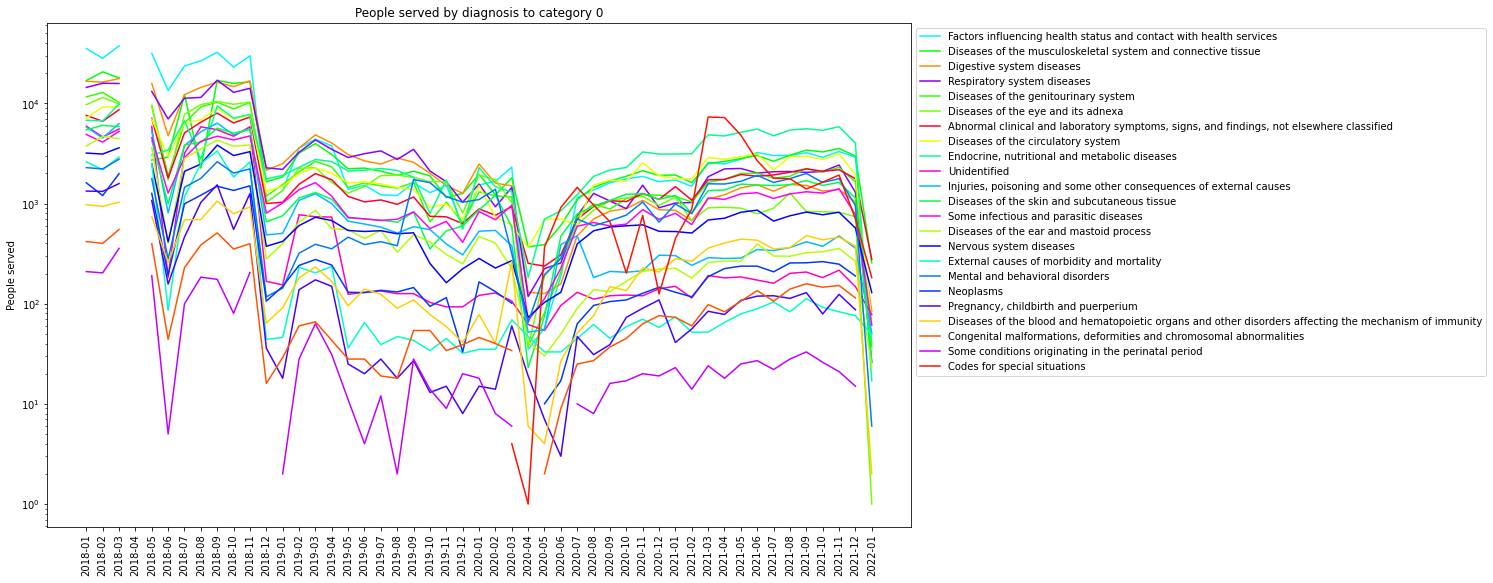

In [57]:

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])


values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    temp_df = temp_df.replace(0, np.nan)
    
    values = temp_df['QTY_PEOPLE_SERVED'].values
    #values = temp_df['PER'].values
    
    ax.plot(values, color=dict_colors[diag], label=diag)
    values_temp = values_temp + values
    i+=1
    
ax.set_ylabel('People served')
ax.set_title('People served by diagnosis to category ' + CATEGORIA_STUDIO)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
ax.set_yscale('log')
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1))
plt.show()


#### Diagnosis to Cat 0 - sector2

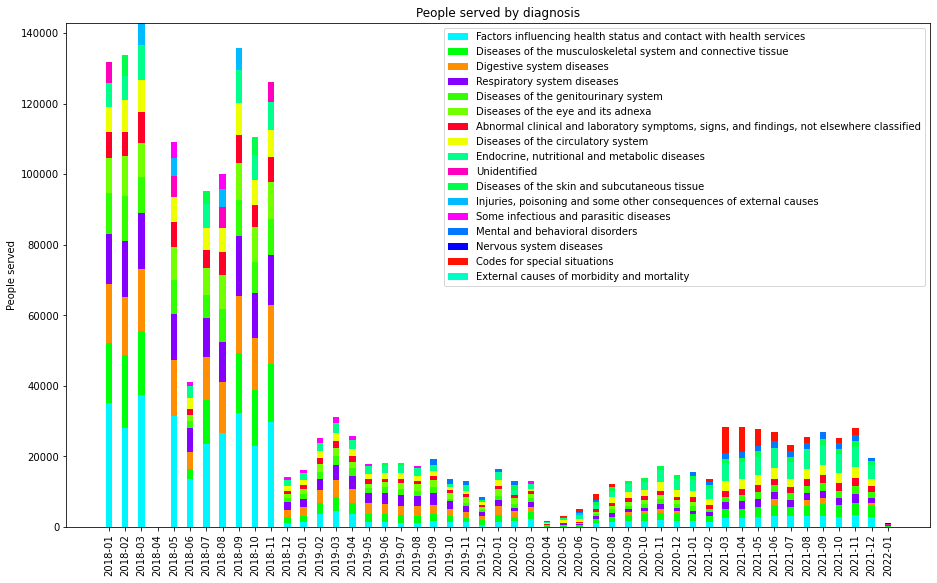

In [46]:

top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1))
plt.show()

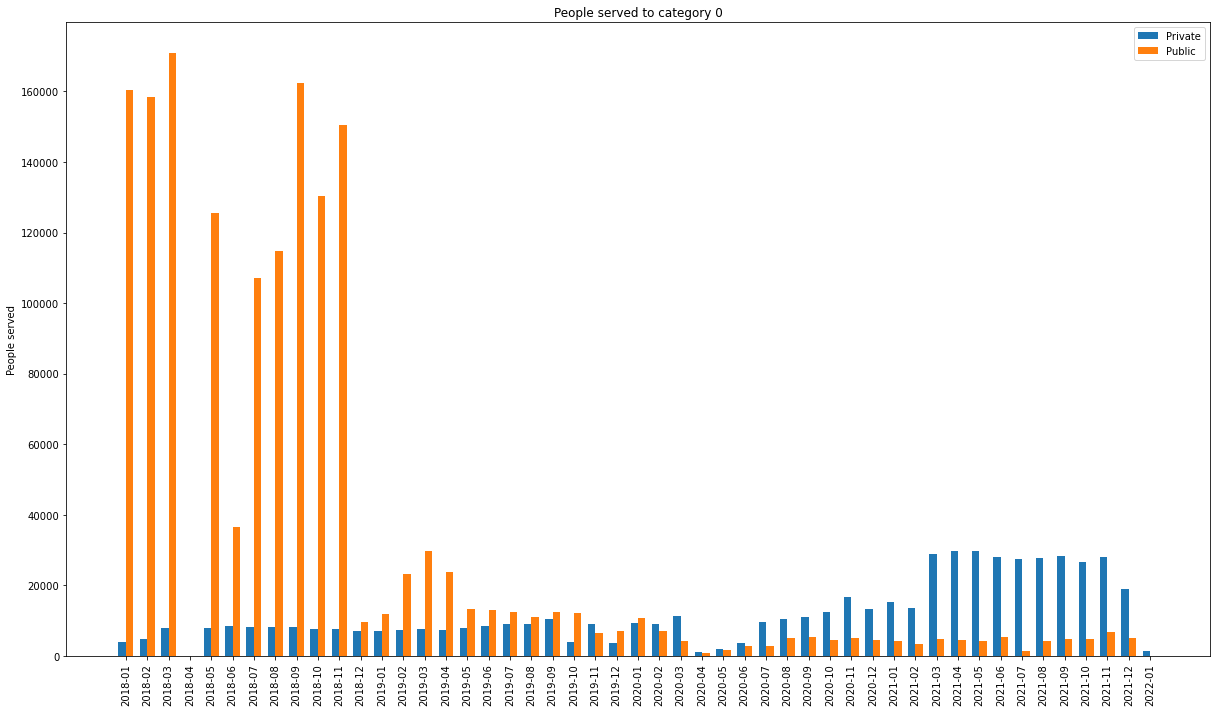

In [53]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp = data_temp.groupby(['DATE','SECTOR2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_temp['QTY_PEOPLE_SERVED'] = data_temp['QTY_PEOPLE_SERVED'].mask(
    (data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4), 0)



date_uniques = data_temp['DATE'].unique()
data_temp_privado = data_temp[data_temp['SECTOR2']=='PRIVADO']
data_temp_publico = data_temp[data_temp['SECTOR2']=='PUBLICO']


dimension = data_temp_privado['SECTOR2'].unique()
for date in date_uniques:
    temp_df = data_temp_privado[data_temp_privado['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SECTOR2'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SECTOR2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_privado = pd.concat([data_temp_privado, temp_df])

    
dimension = data_temp_publico['SECTOR2'].unique()
for date in date_uniques:
    temp_df = data_temp_publico[data_temp_publico['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SECTOR2'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SECTOR2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_publico = pd.concat([data_temp_publico, temp_df])

data_temp_privado = data_temp_privado.sort_values(by=['DATE','SECTOR2'], ascending=True)
data_temp_publico = data_temp_publico.sort_values(by=['DATE','SECTOR2'], ascending=True)


labels = [str(x)[:7] for x in date_uniques]
privado_means = list(data_temp_privado['QTY_PEOPLE_SERVED'])
publico_means = list(data_temp_publico['QTY_PEOPLE_SERVED'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

#fig, ax = plt.subplots()
fig, ax = plt.subplots(1, 1, figsize=(17,10))
rects1 = ax.bar(x - width/2, privado_means, width, label='Private')
rects2 = ax.bar(x + width/2, publico_means, width, label='Public')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('People served')
ax.set_title('People served to category '+ CATEGORIA_STUDIO)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

#ax.yaxis.set_major_formatter(millions)

plt.show()

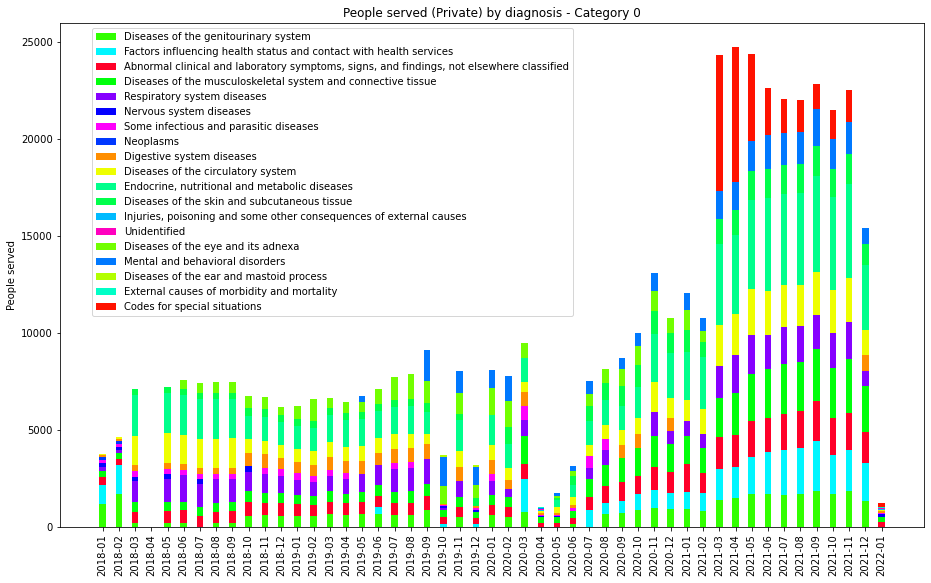

In [50]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp = data_temp[data_temp['SECTOR']=='PRIVADO']

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Private) by diagnosis - Category ' + CATEGORIA_STUDIO)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (0.6, 1))
plt.show()

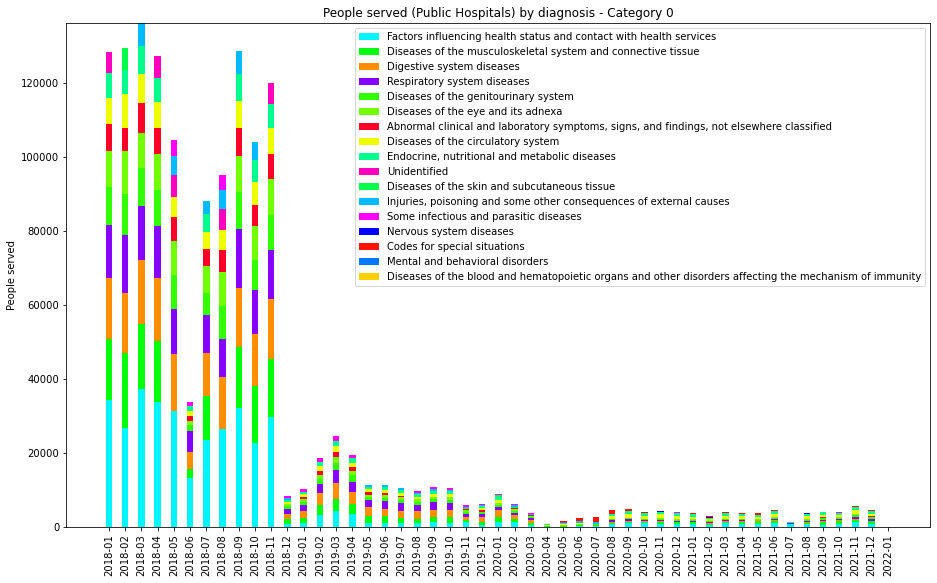

In [49]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp = data_temp[~(data_temp['SECTOR']=='PRIVADO')]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Public Hospitals) by diagnosis - Category ' + CATEGORIA_STUDIO)
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1., 1))
plt.show()

In [71]:
CATEGORIA_STUDIO = '0'

### Private & Public 

In [222]:
all_data.head(3)

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,IS_LIMA,SECTOR2
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,10,PELVIC AND PERINEAL PAIN,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVADO
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,11,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVADO
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,3,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVADO


In [263]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp =  data_temp.groupby(['DATE', 'SECTOR2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = data_temp.pivot_table(index=['DATE'], 
                                  columns=['SECTOR2'], 
                                  values='QTY_PEOPLE_SERVED').fillna(0)
data_temp = data_temp.reset_index()

data_temp.head()

SECTOR2,DATE,PRIVADO,PUBLICO
0,2018-01-01,4052,160299
1,2018-02-01,4925,158328
2,2018-03-01,7812,170994
3,2018-04-01,0,0
4,2018-05-01,7899,125405


In [266]:
import plotly.express as px

df = data_temp
columns_name = list(df.columns)[1:]
fig = px.line(df, 
              x="DATE", 
              y=columns_name,
              hover_data={"DATE": "|%Y %M"},
              labels={
                     "value": "People served (qty)",
                     "DATE": "Date",
                     "variable": "Sector"
                 },
              title='Total people served to Category ' + CATEGORIA_STUDIO)

# fig = px.scatter(data_temp, x="DATE", y=data_temp.columns,
#               hover_data={"DATE": "|%Y %M"},
#               labels={
#                      "value": "People served (qty)",
#                      "DATE": "Date",
#                      "SECTOR2": "Sector"
#                  },
#               title='Total people served to Category ' + CATEGORIA_STUDIO)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")
fig.show()

In [ ]:
TOP_DIAGNOSIS = 10

In [270]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp =  data_temp.groupby(['DATE', 'SECTOR2', 'DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = data_temp.pivot_table(index=['DATE'], 
                                  columns=['SECTOR2','DISEASE_GROUP'], 
                                  values='QTY_PEOPLE_SERVED').fillna(0)
data_temp = data_temp.reset_index()

In [272]:
data_temp

SECTOR2             DATE  \
DISEASE_GROUP              
0             2018-01-01   
1             2018-02-01   
2             2018-03-01   
3             2018-04-01   
4             2018-05-01   
5             2018-06-01   
6             2018-07-01   
7             2018-08-01   
8             2018-09-01   
9             2018-10-01   
10            2018-11-01   
11            2018-12-01   
12            2019-01-01   
13            2019-02-01   
14            2019-03-01   
15            2019-04-01   
16            2019-05-01   
17            2019-06-01   
18            2019-07-01   
19            2019-08-01   
20            2019-09-01   
21            2019-10-01   
22            2019-11-01   
23            2019-12-01   
24            2020-01-01   
25            2020-02-01   
26            2020-03-01   
27            2020-04-01   
28            2020-05-01   
29            2020-06-01   
30            2020-07-01   
31            2020-08-01   
32            2020-09-01   
33            2020-10-01   
34            2020-11-01   
35            2020-12-01   
36            2021-01-01   
37            2021-02-01   
38            2021-03-01   
39            2021-04-01   
40            2021-05-01   
41            2021-06-01   
42            2021-07-01   
43            2021-08-01   
44            2021-09-01   
45            2021-10-01   
46            2021-11-01   
47            2021-12-01   

SECTOR2                                                                                        PRIVADO  \
DISEASE_GROUP Abnormal clinical and laboratory symptoms, signs, and findings, not elsewhere classified   
0                                                          393.0                                         
1                                                          346.0                                         
2                                                          567.0                                         
3                                                            0.0                                         
4                                                          622.0                                         
5                                                          647.0                                         
6                                                          553.0                                         
7                                                          558.0                                         
8                                                          584.0                                         
9                                                          698.0                                         
10                                                         615.0                                         
11                                                         645.0                                         
12                                                         582.0                                         
13                                                         532.0                                         
14                                                         642.0                                         
15                                                         629.0                                         
16                                                         600.0                                         
17                                                         566.0                                         
18                                                         626.0                                         
19                                                         643.0                                         
20                                                         710.0                                         
21                                                         354.0                                         
22                                                     

In [ ]:
top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    #temp_df = temp_df.reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])

In [273]:
df

,DATE,"Abnormal clinical and laboratory symptoms, signs, and findings, not elsewhere classified",Codes for special situations,"Congenital malformations, deformities and chromosomal abnormalities",Digestive system diseases,Diseases of the blood and hematopoietic organs and other disorders affecting the mechanism of immunity,Diseases of the circulatory system,Diseases of the ear and mastoid process,Diseases of the eye and its adnexa,Diseases of the genitourinary system,...,Factors influencing health status and contact with health services,"Injuries, poisoning and some other consequences of external causes",Mental and behavioral disorders,Neoplasms,Nervous system diseases,"Pregnancy, childbirth and puerperium",Respiratory system diseases,Some conditions originating in the perinatal period,Some infectious and parasitic diseases,Unidentified
0,2018-01-01,393.0,0.0,1.0,96.0,0.0,94.0,47.0,1.0,1169.0,...,1015.0,52.0,5.0,123.0,213.0,8.0,241.0,0.0,145.0,69.0
1,2018-02-01,346.0,0.0,2.0,123.0,0.0,104.0,45.0,2.0,1678.0,...,1495.0,44.0,5.0,172.0,152.0,3.0,178.0,0.0,141.0,48.0
2,2018-03-01,567.0,0.0,1.0,305.0,21.0,1534.0,134.0,171.0,216.0,...,146.0,102.0,6.0,48.0,194.0,0.0,1104.0,0.0,303.0,60.0
3,2018-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-05-01,622.0,0.0,3.0,330.0,21.0,1512.0,125.0,171.0,218.0,...,143.0,104.0,8.0,54.0,241.0,3.0,1182.0,0.0,267.0,47.0
5,2018-06-01,647.0,0.0,2.0,321.0,22.0,1530.0,122.0,451.0,213.0,...,185.0,104.0,2.0,48.0,207.0,2.0,1356.0,1.0,246.0,55.0
6,2018-07-01,553.0,0.0,0.0,324.0,22.0,1516.0,127.0,524.0,218.0,...,178.0,95.0,3.0,46.0,228.0,3.0,1224.0,0.0,260.0,58.0
7,2018-08-01,558.0,0.0,0.0,324.0,21.0,1501.0,123.0,559.0,223.0,...,178.0,91.0,5.0,45.0,214.0,10.0,1200.0,0.0,273.0,73.0
8,2018-09-01,584.0,0.0,4.0,318.0,21.0,1508.0,151.0,530.0,226.0,...,186.0,105.0,3.0,48.0,220.0,4.0,1209.0,0.0,270.0,75.0
9,2018-10-01,698.0,0.0,3.0,682.0,17.0,713.0,184.0,601.0,587.0,...,168.0,101.0,1.0,50.0,288.0,15.0,1002.0,0.0,250.0,66.0


In [321]:
row = 1

In [322]:
list_values = df.loc[row, columns_name].values
top_values = list(-np.sort(-list_values)[:5])
top_values 

[1678.0, 1495.0, 346.0, 267.0, 178.0]

In [323]:
new_values = []
for i in list_values:
    if i in top_values:
        new_values.append(i)
    else:
        new_values.append(0)

In [327]:
list_values.size

23

In [ ]:
for i in range(list_values.size)

In [324]:
df.loc[[row],1:] = new_values

C:\Users\johnk\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:719: FutureWarning:

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.



In [325]:
df.loc[row, columns_name].values

array([346.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1678.0, 267.0, 0.0, 0.0,
       0.0, 1495.0, 0.0, 0.0, 0.0, 0.0, 0.0, 178.0, 0.0, 0.0, 0.0],
      dtype=object)

In [310]:
for i in df.loc[1, columns_name]:
    print(i)

346.0
0.0
2.0
123.0
0.0
104.0
45.0
2.0
1678.0
267.0
30.0
63.0
27.0
1495.0
44.0
5.0
172.0
152.0
3.0
178.0
0.0
141.0
48.0


In [279]:
df.loc[df.n == "d", [columns_name]].values.flatten().tolist()

AttributeError: 'DataFrame' object has no attribute 'n'

In [276]:
df = pd.concat([data_temp['DATE'],data_temp['PRIVADO']], axis=1)

columns_name = list(df.columns)[1:]
columns_colors = [dict_colors[i] for i in columns_name]


fig = px.line(df, x="DATE", y=columns_name,
              hover_data={"DATE": "|%B %d, %Y"},
              color_discrete_sequence=columns_colors,
              labels={
                     "value": "People served (qty)",
                     "DATE": "Date",
                     "SECTOR2": "Sector"
                 },
              title='Diagnosis to Category ' + CATEGORIA_STUDIO,
              width=1000, height=1000)


fig.update_layout(legend=dict(yanchor="top",
                              y=-0.3,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")
fig.show()